In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/avito-ml-cup-2025-recsys-data/text_features.pq
/kaggle/input/avito-ml-cup-2025-recsys-data/submit_example.csv
/kaggle/input/avito-ml-cup-2025-recsys-data/test_users.pq
/kaggle/input/avito-ml-cup-2025-recsys-data/cat_features.pq
/kaggle/input/avito-ml-cup-2025-recsys-data/clickstream.pq
/kaggle/input/avito-ml-cup-2025-recsys-data/events.pq


In [2]:
!pip install polars==1.21.0

In [3]:
import polars as pl
import pandas as pd

In [4]:
df_clickstream = pl.read_parquet('/kaggle/input/avito-ml-cup-2025-recsys-data/clickstream.pq')  
df_event = pl.read_parquet('/kaggle/input/avito-ml-cup-2025-recsys-data/events.pq')         
df_test_users = pl.read_parquet('/kaggle/input/avito-ml-cup-2025-recsys-data/test_users.pq')    
df_cat_features = pl.read_parquet('/kaggle/input/avito-ml-cup-2025-recsys-data/cat_features.pq')  
df_text_features = pl.read_parquet('/kaggle/input/avito-ml-cup-2025-recsys-data/text_features.pq') 

In [5]:
contact_ids = (
    df_event
    .filter(pl.col("is_contact") == 1)
    .select("event")
    .to_series()
    .to_list()
)

In [6]:
df_clickstream = df_clickstream.filter(pl.col("event").is_in(contact_ids))

In [7]:
print("Contacts after filtering:", df_clickstream.shape)

Contacts after filtering: (1966247, 7)


After filtering contacts: (1,966,247 rows, 7 columns)
We train the model only on real user "responses" (is_contact=1), not on all actions.

The dataset was reduced from 68,806,152 to 1,966,247 rows.

Next, we filter out the most active noisy users

In [8]:
user_counts = (
    df_clickstream
    .group_by("cookie")
    .agg(pl.count().alias("cnt"))
)

/tmp/ipykernel_13/4203009190.py:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("cnt"))


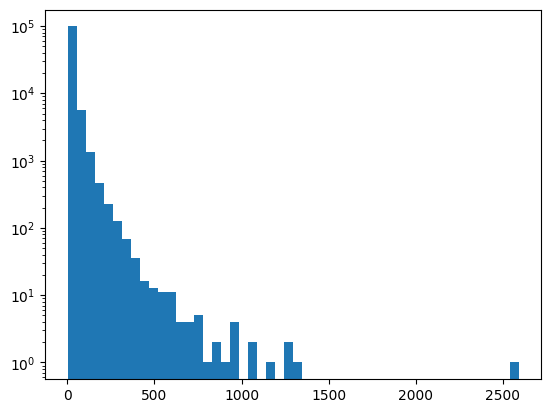

In [9]:
import matplotlib.pyplot as plt
plt.hist(user_counts["cnt"], bins=50)
plt.yscale("log")
plt.show()

In [10]:
super_active = (
    user_counts
    .filter(pl.col("cnt") > 2500)
    .select("cookie")
    .to_series()
    .to_list()
)

In [11]:
super_active

[25540]

In [12]:
df_clickstream = df_clickstream.filter(~pl.col("cookie").is_in(super_active))

In [13]:
print(f"Removed {len(super_active)} super-active users")
print("After filtering noisy users:", df_clickstream.shape)

Removed 1 super-active users
After filtering noisy users: (1963656, 7)


In [14]:
df_clickstream.write_parquet("clickstream_filtered.pq") 